# Understanding Attention

This notebook will help us to understand Bahdanu and Luong Attention

### 1. Setup

In [1]:
# For Google Colaboratory
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

Running as a Jupyter notebook - intended for development only!


In [40]:
# Importing necessary packages
import os, sys
import numpy as np
import zipfile
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
import einops
import torch
from torch.utils.data import DataLoader
import pickle
from torch.utils.data import Dataset
import os
import torch.nn as nn
import math
import time
from torchinfo import summary
from torchview import draw_graph


In [3]:
# Downloading data for attention
if not os.path.exists('data/attention/dataset'):
    !gdown 1ZNJ5sVf5FtdbR7xlbw3ybfiZVd_yXI0p
    os.makedirs('data/attention', exist_ok=True)

    with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('data/attention')
        os.remove('dataset.zip')

DATA_PATH = 'data/attention/dataset/'


In [4]:
# Downloading english and french tokenizer
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 8.2 MB/s eta 0:00:00:00:010:01m
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### 2. Extract dataset

In [5]:
# For this dataset, we are trying to translate french to english
SRC_LANGUAGE = 'fr'
TGT_LANGUAGE = 'en'

In [6]:
# First, we create a custom dataset to load the data. Each item is a pair of french and english datapoint
class CustomDataset(Dataset):
    def __init__(self, train, train_size=10000, test_size=1000, max_len=50):
        self.en_dir = os.path.join("data/attention/dataset", "europarl-v7.fr-en.en")
        self.fr_dir = os.path.join("data/attention/dataset", "europarl-v7.fr-en.fr")
        with open(self.en_dir, "r", encoding="utf8") as f:
            self.english_data = f.readlines()
        with open(self.fr_dir, "r", encoding="utf8") as f:
            self.french_data = f.readlines()
        # Only train on sentences with less than 50 letters
        self.indicies = np.array([i for i in range(len(self.english_data)) if len(self.english_data[i]) < max_len])
        # First 10000 datapoints for train
        if train:
          with open(self.en_dir, "r", encoding="utf8") as f:
              self.english_data = [self.english_data[i] for i in self.indicies][:train_size]
          with open(self.fr_dir, "r", encoding="utf8") as f:
              self.french_data = [self.french_data[i] for i in self.indicies][:train_size]
        # Next 10000 datatpoints for test
        else:
            with open(self.en_dir, "r", encoding="utf8") as f:
                self.english_data = [self.english_data[i] for i in self.indicies][train_size:train_size+test_size]
            with open(self.fr_dir, "r", encoding="utf8") as f:
                self.french_data = [self.french_data[i] for i in self.indicies][train_size:train_size+test_size]
                # self.french_data = f.readlines()[train_size:train_size+test_size]

    def __len__(self):
        return len(self.english_data)

    def __getitem__(self, idx):
        return self.french_data[idx], self.english_data[idx]


In [7]:
# Instantiate dataset
dataset = CustomDataset(train=True)

# Next, we load the tokenizer that transforms the input sentence into tokens
token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [8]:
# Helper function to generate list[list[token]], where each inner list: list[token] is a list of token per sentence.
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [9]:
# For demonstration of yield_tokens() function
for z in iter(dataset):
    print(z) # print out each item in dataset, 0 index contains source language, 1 index contains target language
    print('----')
    print(list(yield_tokens([z], SRC_LANGUAGE))) # Token of source langauge for this item
    print(list(yield_tokens([z], TGT_LANGUAGE))) # Token of source langauge for this item
    break

('Reprise de la session\n', 'Resumption of the session\n')
----
[['Reprise', 'de', 'la', 'session', '\n']]
[['Resumption', 'of', 'the', 'session', '\n']]


In [10]:
# Next, we build the dictionary to convert the tokens to indicies.
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = iter(dataset)
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])

In [12]:
# Functions transform the input sentence to a format that can be used for training
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Adding BOS, EOS and then make tensor
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

In [13]:
# A function does everything and also padding
def collate_fn(src, tgt):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in zip(src, tgt):
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


In [14]:
# Print an example
batch_size = 2
dataset = CustomDataset(train=True)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
# Dataset
print(next(iter(dataset)))

('Reprise de la session\n', 'Resumption of the session\n')


In [16]:
# Dataloader
fr_sentence, eng_sentence = next(iter(train_dataloader))
print(f"Raw Inputs: {fr_sentence}\n{eng_sentence}")

Raw Inputs: ('Il reste au demeurant bien du chemin à parcourir.\n', "Ce n' est pas possible.\n")
('However, we still have a long way to go.\n', 'It is quite out of the question.\n')


In [17]:
# Token transform
fr_token, eng_token = [token_transform["fr"](i.rstrip("\n")) for i in fr_sentence], [token_transform["en"](i.rstrip("\n")) for i in eng_sentence]
print(f"Tokenized Inputs: {fr_token}\n{eng_token}")

Tokenized Inputs: [['Il', 'reste', 'au', 'demeurant', 'bien', 'du', 'chemin', 'à', 'parcourir', '.'], ['Ce', 'n', "'", 'est', 'pas', 'possible', '.']]
[['However', ',', 'we', 'still', 'have', 'a', 'long', 'way', 'to', 'go', '.'], ['It', 'is', 'quite', 'out', 'of', 'the', 'question', '.']]


In [18]:
# Vocab transform
fr_idx, eng_idx = [vocab_transform["fr"](i) for i in fr_token], [vocab_transform["en"](i) for i in eng_token]
print(f"Tokenized Inputs to indicies: {fr_idx}\n{eng_idx}")

Tokenized Inputs to indicies: [[28, 259, 61, 5431, 90, 39, 596, 10, 3150, 5], [57, 116, 13, 6, 17, 413, 5]]
[[158, 8, 28, 176, 29, 13, 242, 178, 9, 183, 5], [30, 6, 165, 169, 12, 7, 95, 5]]


In [19]:
# Tensor transform
fr_pad, eng_pad = [tensor_transform(i) for i in fr_idx], [tensor_transform(i) for i in eng_idx]
print(f"Tokenized Indicies with begin (2) and end token (3): {fr_pad}\n{eng_pad}")

Tokenized Indicies with begin (2) and end token (3): [tensor([   2,   28,  259,   61, 5431,   90,   39,  596,   10, 3150,    5,    3]), tensor([  2,  57, 116,  13,   6,  17, 413,   5,   3])]
[tensor([  2, 158,   8,  28, 176,  29,  13, 242, 178,   9, 183,   5,   3]), tensor([  2,  30,   6, 165, 169,  12,   7,  95,   5,   3])]


In [20]:
# # Lastly, we pad the rest of the sentence
# This also changes the shape from (bs, seq_len) to (seq_len, bs)
fr_pad, eng_pad = pad_sequence(fr_pad, padding_value=PAD_IDX), pad_sequence(eng_pad, padding_value=PAD_IDX)
print(f"After padding (1): {fr_pad}\n{eng_pad}")

After padding (1): tensor([[   2,    2],
        [  28,   57],
        [ 259,  116],
        [  61,   13],
        [5431,    6],
        [  90,   17],
        [  39,  413],
        [ 596,    5],
        [  10,    3],
        [3150,    1],
        [   5,    1],
        [   3,    1]])
tensor([[  2,   2],
        [158,  30],
        [  8,   6],
        [ 28, 165],
        [176, 169],
        [ 29,  12],
        [ 13,   7],
        [242,  95],
        [178,   5],
        [  9,   3],
        [183,   1],
        [  5,   1],
        [  3,   1]])


In [21]:
# All the above is combined into collate_fn
x, y = collate_fn(fr_sentence, eng_sentence)
print(f"Same Outputs: {x}\n{y}")

Same Outputs: tensor([[   2,    2],
        [  28,   57],
        [ 259,  116],
        [  61,   13],
        [5431,    6],
        [  90,   17],
        [  39,  413],
        [ 596,    5],
        [  10,    3],
        [3150,    1],
        [   5,    1],
        [   3,    1]])
tensor([[  2,   2],
        [158,  30],
        [  8,   6],
        [ 28, 165],
        [176, 169],
        [ 29,  12],
        [ 13,   7],
        [242,  95],
        [178,   5],
        [  9,   3],
        [183,   1],
        [  5,   1],
        [  3,   1]])


## Luong Attention

Implement GRU-based seq2seq model with Luong attention (https://arxiv.org/pdf/1508.04025.pdf) and train the model on the french to english translation dataset. (the use of the function nn.GRU() is allowed but the attention scheme needs to be implemented **explicitly**) :

The Luong attention algorithm performs the following operations:

1. The encoder generates a set of hidden states, $H = \textbf{h}_i, i = 1, 2, .....T$ , from the input sentence. The decoder generates a set of hidden states, $S = \textbf{s}_t, t =1, 2, .....$.
2. The current decoder hidden state is computed as: $\textbf{s}_t = GRU_{decoder}(\textbf{s}_{t-1}, y_{t-1})$. Here, $\textbf{s}_{t-1}$ denotes the previous hidden decoder state, and $y_{t-1}$ the current input, which is also the expected output for the previous timestep.

3. A dot product on the encoder hidden state $\textbf{h}_i$ and the current decoder hidden state $\textbf{s}_t$ to compute the alignment scores: $e_{t,i} = \textbf{s}_t . \textbf{h}_i$. 

4. A softmax function is applied to the alignment scores, effectively normalizing them into attention weights in a range between 0 and 1: $\alpha_{t, i} = \text{softmax}(e_{t, i}/ \textbf{e}_t)$.

5. These attention weights together with the encoder hidden states are used to generate a context vector through a weighted sum: $\textbf{c}_t = \sum_{i=1}^T\alpha_{t, i}\textbf{h}_i$.

6. An attentional hidden state is computed based on a weighted concatenation of the context vector and the current decoder hidden state: $\tilde{\textbf{s}_t} = \text{tanh}\big(W_c\big[\textbf{c}_t; \textbf{s}_t\big]\big)$.

7. The decoder produces a final output by feeding it a weighted attentional hidden state: $y_t = \text{softmax}(W_y\tilde{\textbf{s}_t})$.

8. Steps 2-7 are repeated until the end of the sequence. 

The attention has to be calculated in parallel via matrix multiplication. For loop $\textbf{should not}$ be used.


In [58]:
# Fill UP ATTENTION NETWORK
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()

        # for encoder
        self.encoder_embedding = nn.Embedding(num_embeddings=SRC_VOCAB_SIZE, embedding_dim=hidden_size)
        self.gru_encoder = nn.GRU(hidden_size, hidden_size)

        # for decoder
        self.decoder_embedding = nn.Embedding(num_embeddings=TGT_VOCAB_SIZE, embedding_dim=hidden_size)
        self.gru_decoder = nn.GRU(hidden_size, hidden_size)

        self.weighted_concat = nn.Linear(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size, TGT_VOCAB_SIZE)


    def forward(self, x, y, h_init):
        # x shape (seq_length, batch_size)
        # y shape (seq_length, batch_size)
        # h_init (1, batch_size, hidden_dim)

        # encoder
        # Shape (seq, batch, hidden_dim)
        encoder_embedded = self.encoder_embedding(x)
        # encoder_outputs (seq, batch_size, hidden_dim)
        # encoder_hidden (batch_size, hidden_dim)
        encoder_outputs, encoder_hidden = self.gru_encoder(encoder_embedded, h_init)

        # decoder
        # for now sequential:
        # Shape (batch_size, hidden_dim)
        decoder_hidden = encoder_hidden

        # shape (seq_len, batch_size, hidden_dim)
        decoder_embedded = self.decoder_embedding(y)
        # decoder_outputs (seq, batch_size, hidden_dim)
        # decoder_hidden (batch_size, hidden_dim)
        decoder_outputs, decoder_hidden = self.gru_decoder(decoder_embedded, decoder_hidden)

        # alignment score using dot product
        # For each of the decoder hidden seq_out_[s], whose dimensions is [i], we dot product with
        # every encoder hidden seq_in_[x], whose dimensions is [i], so that it is a scalar number for
        # each [s,x]. Here we use einsum: sbi means the (seq_out_size, batch, dims),
        # xbi means (seq_in_size, batch, dims), and we dot product of the last dimensions so in total
        # the results is size_out, batch, size_in

        # Shape (seq_out, batch, seq_in)
        alignment_score = torch.einsum('sbi,xbi->sbx', [decoder_outputs, encoder_outputs])

        #Shape (seq_out, batch, seq_in), if we sum over seq_in, we see probabilities = 1
        # this mean for each seq_out, which token in seq_in to attend to
        attention_weights = torch.nn.functional.softmax(alignment_score, dim=-1)

        # The context is just the weighted of encoder_outputs by the attention_weights,
        # attention_weights (seq_out, batch, seq_in), for each seq_out_[s] whose
        # seq_in_[x] (a constant) contains probability, we multiply with encoder_outputs dimesions at each
        # seq_in_[x] and summing together to acehive weighted encoder_outputs dim

        # Shape (batch, seq_out, dim) # This calculates weights of each token in seq_out
        context = torch.einsum('sbx,xbj->sbj', [attention_weights, encoder_outputs])

        # Shape (seq_out, batch, dim*2)
        concat_features = torch.cat([decoder_outputs, context], dim=-1)

        # Shape (seq_out, batch, dim)
        s_tilded = torch.tanh(self.weighted_concat(concat_features))

        # Shape (seq_out, batch, VOCAB_SIZE)
        output = self.out(s_tilded) # Swap batch size to first

        return output

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
# We use torchinfo to visualize the LuongAttention networks
batch_size = 8
seq_length_in = 10
seq_length_out = 15
hidden_dim = 32
net = LuongAttention(hidden_dim)

summary(net.to(device), input_size= [(seq_length_in, batch_size), (seq_length_out, batch_size),
                          (1, batch_size, hidden_dim)],
        dtypes=[torch.int, torch.int, torch.float])

Layer (type:depth-idx)                   Output Shape              Param #
LuongAttention                           [15, 8, 6278]             --
├─Embedding: 1-1                         [10, 8, 32]               249,504
├─GRU: 1-2                               [10, 8, 32]               6,336
├─Embedding: 1-3                         [15, 8, 32]               200,896
├─GRU: 1-4                               [15, 8, 32]               6,336
├─Linear: 1-5                            [15, 8, 32]               2,080
├─Linear: 1-6                            [15, 8, 6278]             207,174
Total params: 672,326
Trainable params: 672,326
Non-trainable params: 0
Total mult-adds (M): 9.91
Input size (MB): 0.00
Forward/backward pass size (MB): 6.16
Params size (MB): 2.69
Estimated Total Size (MB): 8.85

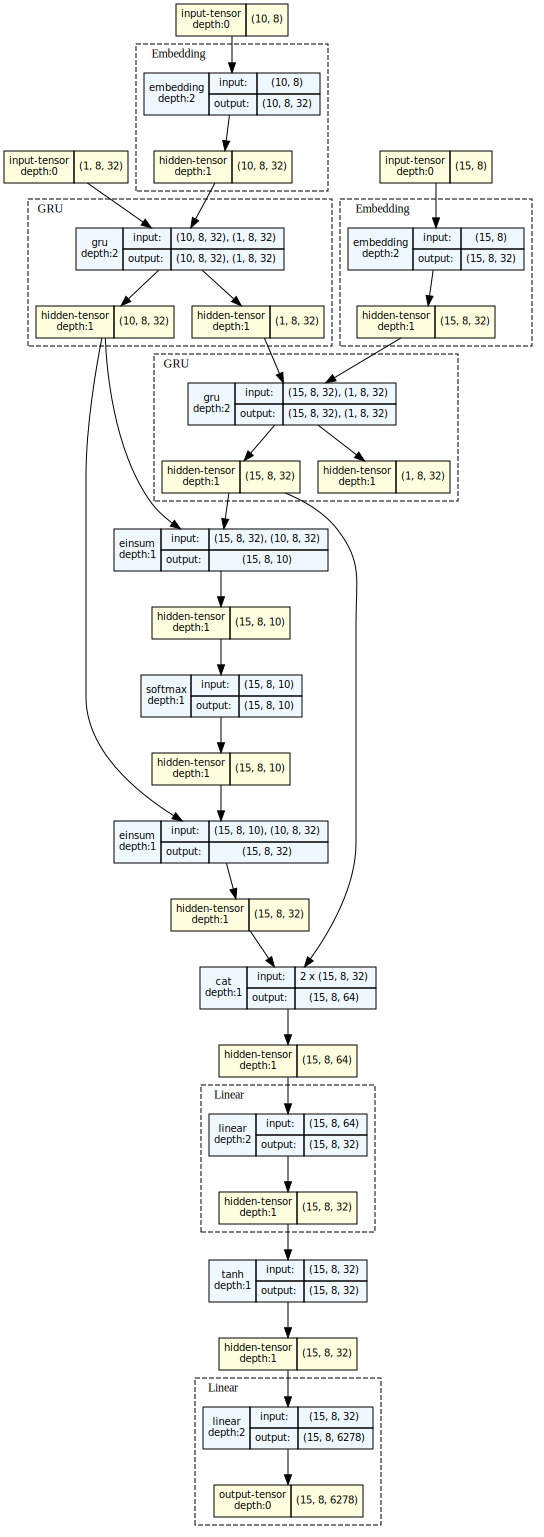

In [61]:
model_graph = draw_graph(net.to(device),
                         input_size= [(seq_length_in, batch_size), (seq_length_out, batch_size),
                          (1, batch_size, hidden_dim)],
        dtypes=[torch.int, torch.int, torch.float], roll=True, expand_nested=True,
                         hide_module_functions=False, hide_inner_tensors=False)
model_graph.visual_graph


In [54]:
model_graph.visual_graph.render('temp_roll')

'./temp_roll.pdf'

In [67]:
import gc
# Hyperparameters
num_epochs = 5
hidden_size = 256
my_lr = 1.3
bs = 32

# Variables
train_dataset = CustomDataset(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataset = CustomDataset(train=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
net = LuongAttention(hidden_size)

print(net)

net = net.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


LuongAttention(
  (encoder_embedding): Embedding(7797, 256)
  (gru_encoder): GRU(256, 256)
  (decoder_embedding): Embedding(6278, 256)
  (gru_decoder): GRU(256, 256)
  (weighted_concat): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=6278, bias=True)
)


In [63]:
def eval_on_test_set():

    running_loss=0
    num_batches=0

    h = torch.zeros(1, bs, hidden_size)

    h=h.to(device)

    for x, y in test_dataloader:
        x, y = collate_fn(x, y)
        # Batch size might be different for the last batch
        batch_size = x.size()[1]
        seq_length = y.size()[0] - 1
        # set the initial h to be the zero vector
        h = torch.zeros(1, batch_size, hidden_size)
        # send them to the gpu
        minibatch_data=x.type(torch.LongTensor).to(device)
        minibatch_label=y.type(torch.LongTensor).to(device)
        h=h.to(device)

        # FILL UP FORWARD PASS
        scores = net(minibatch_data, minibatch_label, h)
        #minibatch_label = torch.swapaxes(minibatch_label, 0, 1)
        #scores = scores[:, :-1, :] #
        minibatch_label = minibatch_label[:, 1:]
        loss = criterion(torch.swapaxes(scores, 1, 2), minibatch_label)
        # END OF FORWARD PASS

        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()

        # update the running loss
        running_loss += loss.detach().item()
        num_batches += 1
        # Collect garbage to prevent OOM
        gc.collect()

    total_loss = running_loss/num_batches
    print('test: exp(loss) = ', math.exp(total_loss)  )
    return math.exp(total_loss)

In [64]:
def normalize_gradient(net):

    grad_norm_sq=0

    for p in net.parameters():
        grad_norm_sq += p.grad.data.norm()**2

    grad_norm=math.sqrt(grad_norm_sq)

    if grad_norm<1e-4:
        net.zero_grad()
        print('grad norm close to zero')
    else:
        for p in net.parameters():
            p.grad.data.div_(grad_norm)

    return grad_norm

In [77]:
start = time.time()
def train(my_lr):
    for epoch in range(num_epochs):
      # keep the learning rate to 1 during the first 4 epochs, then divide by 1.1 at every epoch
        if epoch >= 4:
            my_lr = my_lr / 1.1

        # create a new optimizer and give the current learning rate.
        optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )

        # set the running quantities to zero at the beginning of the epoch
        running_loss=0
        num_batches=0

        for x, y in train_dataloader:
            # Set the gradients to zeros
            optimizer.zero_grad()
            # Transform inputs
            x, y = collate_fn(x, y)
            # Batch size might be different for the last batch
            batch_size = x.size()[1]
            seq_length = y.size()[0] - 1
            # set the initial h to be the zero vector
            h = torch.zeros(1, batch_size, hidden_size)
            # send them to the gpu
            minibatch_data=x.type(torch.LongTensor).to(device)
            minibatch_label=y.type(torch.LongTensor).to(device)
            h=h.to(device)

            # FILL UP FORWARD PASS
            scores = net(minibatch_data, minibatch_label, h) # Output is (seq, bs, dims)
            # Label must have shape (batch_size, seq)
            minibatch_label = torch.einsum('sb->bs', [minibatch_label])[:, 1:]
            # Scores must have shape (batch, dims, seq)
            # In torch document, input shape (N,C,d_1,...,d_k), where C is class which means
            # dims is class because it outputs the probabilities of vocab size
            scores = torch.einsum('sbd->bds', [scores])[:, :, :-1]
            loss = criterion(scores, minibatch_label)
            # END OF FORWARD PASS

            # backward pass to compute dL/dR, dL/dV and dL/dW
            loss.backward()

            # do one step of stochastic gradient descent: R=R-lr(dL/dR), V=V-lr(dL/dV), ...
            normalize_gradient(net)
            optimizer.step()
            # update the running loss
            running_loss += loss.detach().item()
            num_batches += 1
            # Collect garbage to prevent OOM
            gc.collect()
        # compute stats for the full training set
        total_loss = running_loss / num_batches
        elapsed = time.time() - start

        print('')
        print('epoch=',epoch, '\t time=', elapsed,'\t lr=', my_lr, '\t exp(loss)=',  math.exp(total_loss))
        #eval_on_test_set()

train(my_lr=my_lr)


epoch= 0 	 time= 52.48261547088623 	 lr= 1.3 	 exp(loss)= 128.35715908107403

epoch= 1 	 time= 105.0176751613617 	 lr= 1.3 	 exp(loss)= 40.80311326012056

epoch= 2 	 time= 157.5245852470398 	 lr= 1.3 	 exp(loss)= 24.970665743638587

epoch= 3 	 time= 210.24461817741394 	 lr= 1.3 	 exp(loss)= 17.483279475864972

epoch= 4 	 time= 263.1889922618866 	 lr= 1.1818181818181817 	 exp(loss)= 12.57862863031868


In [78]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

count = 0
for x, y in test_dataloader:
    print(x)
    # set the initial h to be the zero vector
    h = torch.zeros(1, 1, hidden_size)

    # send it to the gpu    
    h=h.to(device)
    x, y = collate_fn(x, y)
    # send them to the gpu
    minibatch_data=x.type(torch.LongTensor).to(device)
    # The first prediction is the start of sentence index
    start_index = torch.tensor([[2]]).type(torch.LongTensor).to(device)
    predictions=start_index
    for _ in range(20):
      # At every loop, pass in the previous predictions
      predictions = net.forward(minibatch_data, predictions, h)
      predictions = torch.reshape(predictions, (-1, TGT_VOCAB_SIZE, 1))
      # Get the new predictions shifted right by 1 timestep
      predictions = torch.argmax(predictions, dim=1)
      # Add back the first timestep
      predictions = torch.cat([start_index, predictions], 0)
      if predictions[-1].item() == 3:
          break
    predictions = predictions.reshape(-1)
    # Transform from token to words
    predictions = [vocab_transform[TGT_LANGUAGE].lookup_token(i) for i in predictions]
    print(f"Label: {[vocab_transform[TGT_LANGUAGE].lookup_token(i) for i in y]}")
    print(f"Predicted: {predictions}")
    count += 1
    if count > 10:
        break

('Mais qui a peur ?\n',)
Label: ['<bos>', 'But', 'who', 'fears', ',', 'exactly', '?', '<eos>']
Predicted: ['<bos>', 'Why', 'are', 'we', 'to', 'be', 'done', '?', '<eos>']
('Sapristi, mais quelle Europe est-ce donc ? !\n',)
Label: ['<bos>', 'For', '<unk>', "'s", 'sake', '!', 'What', 'sort', 'of', 'Europe', 'is', 'this', '?', '<eos>']
Predicted: ['<bos>', 'What', 'is', 'this', 'be', 'approved', '!', '<eos>']
('Pourquoi cette omission ?\n',)
Label: ['<bos>', 'Why', 'is', 'this', '?', '<eos>']
Predicted: ['<bos>', 'Why', '?', '<eos>']
('Ce sera ma première question.\n',)
Label: ['<bos>', 'That', 'is', 'my', 'first', 'question', '.', '<eos>']
Predicted: ['<bos>', 'It', 'is', 'a', 'question', '.', '<eos>']
("Nous sommes d'accord !\n",)
Label: ['<bos>', 'We', 'agree', '.', '<eos>']
Predicted: ['<bos>', 'We', 'are', 'all', 'for', 'this', '!', '<eos>']
("Je suis encore bouleversé et choqué par ce que j'ai vu.\n",)
Label: ['<bos>', 'I', 'am', 'still', '<unk>', 'from', 'the', 'shock', '.', '<eos>'